# 使用k-近邻算法改进约会网站的配对效果

In [1]:
import numpy as np
import operator, os

## k-近邻算法

In [2]:
def classify0(inX, dataSet, labels, k):
    # 获取矩阵行数
    dataSetSize = dataSet.shape[0]
    # 计算距离
    diffMat = np.tile(inX, (dataSetSize, 1)) - dataSet
    sqDiffMat = diffMat ** 2
    sqDistances = sqDiffMat.sum(axis=1)
    distances = sqDistances ** 0.5
    sortedDistIndicies = distances.argsort()
    # 选择距离最小的k个点
    classCount = {}
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1
    # 排序
    sortedClassCount = sorted(classCount.items(),
                              key=operator.itemgetter(1),
                              reverse=True)
    return sortedClassCount[0][0]

## 读取文件数据，获得特征值矩阵和分类向量

In [3]:
def file2matrix(fileName):
    # 标记极具魅力的人为3，魅力一般的人为2，不喜欢的人为1
    love_dictionary = {'largeDoses':3, 'smallDoses':2, 'didntLike':1}
    fr = open(fileName)
    arrayOLines = fr.readlines()
    # 取得文件行数
    numberOfLines = len(arrayOLines)
    # 创建返回的Numpy矩阵
    returnMat = np.zeros((numberOfLines, 3))
    # 解析文件数据到列表
    classLabelVector = []
    index = 0
    for line in arrayOLines:
        line = line.strip()
        listFromLine = line.split('\t')
        returnMat[index, :] = listFromLine[0:3]
        # 判断最后的标识，如果为数字则转换之后保存到数组中，如果不是数字，
        # 将文字转换为标识数字再保存
        if listFromLine[-1].isdigit():
            classLabelVector.append(int(listFromLine[-1]))
        else:
            classLabelVector.append(love_dictionary.get(listFromLine[-1]))
        index += 1
    return returnMat, classLabelVector

## 准备数据：解析文件获得数据，datingDataMat为特征值矩阵，datingLabels为分类向量

In [21]:
datingDataMat, datingLabels = file2matrix(
    os.path.abspath('Week1\MyHomeWork\datingTestSet.txt'))

## 特征值矩阵

In [5]:
datingDataMat

array([[4.0920000e+04, 8.3269760e+00, 9.5395200e-01],
       [1.4488000e+04, 7.1534690e+00, 1.6739040e+00],
       [2.6052000e+04, 1.4418710e+00, 8.0512400e-01],
       ...,
       [2.6575000e+04, 1.0650102e+01, 8.6662700e-01],
       [4.8111000e+04, 9.1345280e+00, 7.2804500e-01],
       [4.3757000e+04, 7.8826010e+00, 1.3324460e+00]])

## 分类向量：展现前20个

In [7]:
datingLabels[:20]

[3, 2, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3]

## 分析数据

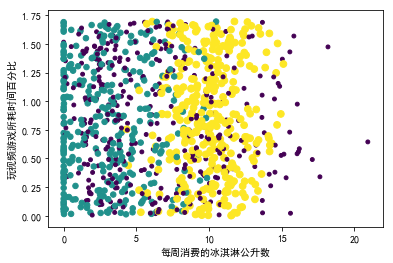

In [8]:
import matplotlib.pyplot as plt
plt.figure()
# 彩色效果
# 矩阵第二列和第三列属性来展示数据
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.xlabel("每周消费的冰淇淋公升数")
plt.ylabel("玩视频游戏所耗时间百分比")
plt.scatter(datingDataMat[:, 1], datingDataMat[:, 2], 
            15.0*np.array(datingLabels), 15.0*np.array(datingLabels))
plt.show()


In [9]:
datingDataMat[:,1][996]

9.974715

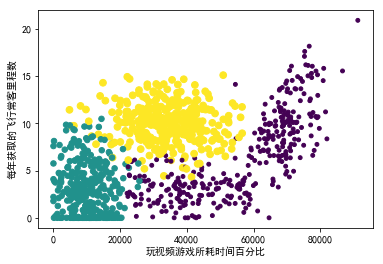

In [10]:
# 矩阵第一列和第二列属性来展示数据
plt.xlabel("玩视频游戏所耗时间百分比")
plt.ylabel("每年获取的飞行常客里程数")
plt.scatter(datingDataMat[:, 0], datingDataMat[:, 1],
            c=15.0*np.array(datingLabels),s=15.0*np.array(datingLabels))
plt.show()


## 准备数据：归一化数值

### 归一化特征值

In [11]:
def autoNorm(dataSet):
   # 取出最小值, 0表示从列中取，不加参数是从行中取
   minVals = dataSet.min(0)
   # 取出最大值
   maxVals = dataSet.max(0)
   ranges = maxVals - minVals
   m = dataSet.shape[0]
   normDataSet = dataSet - np.tile(minVals, (m, 1))
   normDataSet = normDataSet / np.tile(ranges, (m, 1))
   return normDataSet, ranges, minVals

### 获取归一化矩阵、取值范围、最小值归一化数据

In [12]:
normMat, ranges, minVals = autoNorm(datingDataMat)

#### 归一化矩阵

In [13]:
normMat

array([[0.44832535, 0.39805139, 0.56233353],
       [0.15873259, 0.34195467, 0.98724416],
       [0.28542943, 0.06892523, 0.47449629],
       ...,
       [0.29115949, 0.50910294, 0.51079493],
       [0.52711097, 0.43665451, 0.4290048 ],
       [0.47940793, 0.3768091 , 0.78571804]])

#### 取值范围

In [14]:
ranges

array([9.1273000e+04, 2.0919349e+01, 1.6943610e+00])

#### 最小值归一化

In [15]:
minVals

array([0.      , 0.      , 0.001156])

## 测试算法

### 分类器针对约会网站的测试代码

In [16]:
def datingClassTest():
    hoRatio = 0.10
    # 返回 特征矩阵，分类向量
    datingDataMat, datingLabels = file2matrix(os.path.abspath('Week1\MyHomeWork\datingTestSet.txt'))  
    # 返回归一化数据结果、数据范围、归一化最小值
    normMat, ranges, minVals = autoNorm(datingDataMat) 
    # 获得normMat的行数
    m = normMat.shape[0]
    numTestVecs = int(m*hoRatio)
    # 错误计数
    errorCount = 0.0  
     # 前numTestVecs个数据作为测试集
    for i in range(numTestVecs):
        classifierResult = classify0(normMat[i,:], normMat[numTestVecs:m,:], datingLabels[numTestVecs:m], 3)
        print("the classifier came back with: %d, the real answer is: %d" % (classifierResult, datingLabels[i]))
        # 判断分类结果，如果出错，则errorCount加1
        if classifierResult != datingLabels[i]: 
            errorCount += 1.0
    # 打印错误率
    # print("the error is:", errorCount)  # test the value of error
    print("the total error rate is: %f" % (errorCount/float(numTestVecs)))  

### 调用测试代码

In [17]:
datingClassTest()

the classifier came back with: 3, the real answer is: 3
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answe

采用datingTestSet.txt数据集可测试出错误率是5%

## 使用算法：构建完整可用系统

In [19]:
def classifyPerson(testData=False):
    # 输出结果
    resultList = ['not at all', 'in small doses', 'in large doses']
    if testData:
        percentTats = float(10)
        ffMiles = float(10000)
        iceCream = float(0.5)
    else:
        # 玩视频游戏所耗时间百分比
        percentTats = float(input("percentage of time spent playing video game ?"))  
        # 每年获得的飞行常客里程数
        ffMiles = float(input("frequent filer miles earned per year ?"))
        # 每周消费的冰淇淋公升数
        iceCream = float(input("liters of ice cream consumed per year ?"))
        
    # 分析数据
    datingDataMat, datingLabels = file2matrix(os.path.abspath('Week1\MyHomeWork\datingTestSet2.txt'))
    # 归一化数据
    normMat, ranges, minVals = autoNorm(datingDataMat)
    # 将输入数据生成特征值矩阵
    inArr = np.array([ffMiles, percentTats, iceCream])
    # 进行k-近邻算法预测
    classifierResult = classify0((inArr-minVals)/ranges,normMat, datingLabels,3)
    # 输出分类的结果
    print("you will probably like this person :", resultList[classifierResult - 1])

In [20]:
classifyPerson(testData=True)

you will probably like this person : in small doses


当输入数据为10，10000，0.5时，得到的结果是魅力一般